In [2]:
import numpy as np
import tools21cm as t2c
from sklearn.metrics import matthews_corrcoef
import matplotlib.pyplot as plt
from pathlib import Path
from typing import NamedTuple, Annotated, Literal
import numpy.typing as npt
import os
import requests


In [3]:
FloatArrayNxNxN = Annotated[npt.NDArray[np.float_], Literal["N", "N", "N"]]
FloatArrayN = Annotated[npt.NDArray[np.float_], Literal["N"]]

class XFracDensLoaded(NamedTuple):
    """The Xfrac and dens files loaded into memory."""

    x_file: t2c.XfracFile
    """Loaded xfrac file object."""

    d_file: t2c.DensityFile
    """Loaded density file object."""

    x_frac: FloatArrayNxNxN
    """xfrac values in a 3D cube N*N*N."""

    dens: FloatArrayNxNxN
    """Density values in a 3D cub N*N*N."""

    z: float
    """Redshift value"""

    box_dims: float
    """Length of the volume along each direction in [Mpc]."""

    def xy_dims(self) -> tuple[FloatArrayN, FloatArrayN]:
        """
        Get the x, y dimensions of the loaded.

        Returns
        -------
        tuple[FloatArrayN, FloatArrayN]
            A tuple containing the x and y labels.
        """
        dx, dy = (
            self.box_dims / self.x_frac.shape[1],
            self.box_dims / self.x_frac.shape[2],
        )
        y, x = np.mgrid[
            slice(dy / 2, self.box_dims, dy), slice(dx / 2, self.box_dims, dx)
        ]
        return x, y

class DownloadObject:
    def __init__(
        self,
        name: str,
        url: str,
    ) -> None:
        self.name = name
        self.url = url
        directory = "./to-be-deleted-cache"
        os.makedirs(directory, exist_ok=True)
        self.path = f"{directory}/{name}"

    def __download(self) -> None:
        response = requests.get(self.url)
        open(self.path, "wb").write(response.content)

    def __is_downloaded(self) -> bool:
        if os.path.exists(self.path):
            return True
        return False

    def get(self) -> str:
        if not self.__is_downloaded():
            print(
                f"{self.name} is not downloaded yet. "
                + "Downloading and caching for future uses..."
            )
            self.__download()
        return self.path

class XFracDensFilePair(NamedTuple):
    """A pair of matching XFrac and dens files (Same Redshift value)."""

    xfrac_path: Path
    """Path to the x-frac file."""

    dens_path: Path
    """Path to the dens file."""

    box_dims: float
    """Length of the volume along each direction in [Mpc]."""

    def load(self) -> XFracDensLoaded:
        """
        Load the files into memory.

        Returns
        -------
        XFracDensLoaded
            The loaded files.
        """
        x_file = t2c.XfracFile(self.xfrac_path)
        d_file = t2c.DensityFile(self.dens_path)

        return XFracDensLoaded(
            x_file=x_file,
            d_file=d_file,
            x_frac=x_file.xi,
            dens=d_file.cgs_density,
            z=x_file.z,
            box_dims=self.box_dims,
        )

def get_xfrac_dens_file(z: float, box_dims: float) -> XFracDensFilePair:
    """
    Get the xfrac and dens files from the server.

    They are downloaded and cached on the first access.

    Parameters
    ----------
    z : float
        Redshift value.
    box_dims : float
        Box dimensions used for these files.

    Returns
    -------
    XFracDensFilePair
        A tuple of xfrac and dens files.
    """
    xfrac_name = f"xfrac3d_{z:.3f}.bin"
    dens_name = f"{z:.3f}n_all.dat"

    xfrac_path = DownloadObject(
        xfrac_name,
        f"https://ttt.astro.su.se/~gmell/244Mpc/244Mpc_f2_0_250/{xfrac_name}",
    ).get()
    dens_path = DownloadObject(
        dens_name,
        "https://ttt.astro.su.se/~gmell/244Mpc/densities/nc250/coarser_densities/"
        + f"{dens_name}",
    ).get()

    return XFracDensFilePair(
        xfrac_path=Path(xfrac_path), dens_path=Path(dens_path), box_dims=box_dims
    )

In [4]:
t2c.set_sim_constants(244) # This line is only useful while working with C2Ray simulations.

z = 7.059
box_dims = 244/0.7 # Length of the volume along each direction in Mpc.
boxsize = 244/0.7 # in Mpc

z_file = get_xfrac_dens_file(z=z, box_dims=box_dims)
x_file, d_file, *_ = z_file.load()

xfrac = x_file.xi
dens  = d_file.cgs_density

dx, dy = box_dims/xfrac.shape[1], box_dims/xfrac.shape[2]
y, x = np.mgrid[slice(dy/2,box_dims,dy),
                slice(dx/2,box_dims,dx)]

dT = t2c.calc_dt(xfrac, dens, z)
# print('Mean of first channel: {0:.4f}'.format(dT[0].mean()))
dT_subtracted = t2c.subtract_mean_signal(dT, 0)
# print('Mean of first channel: {0:.4f}'.format(dT_subtracted[0].mean()))

uv, Nant = t2c.get_uv_daily_observation(ncells=dT.shape[0], # The number of cell used to make the image
                                        z=z,                # Redhsift of the slice observed
                                        filename=None,      # If None, it uses the SKA-Low 2016 configuration.
                                        total_int_time=6.0, # Observation per day in hours.
                                        int_time=10.0,      # Time period of recording the data in seconds.
                                        boxsize=boxsize,    # Comoving size of the sky observed
                                        declination=-30.0,
                                        verbose=True)

noise_cube = t2c.noise_cube_coeval(ncells=dT.shape[0],
                                   z=z,
                                   depth_mhz=None,   #If None, estimates the value such that the final output is a cube.
                                   obs_time=1000,
                                   filename=None,
                                   boxsize=boxsize,
                                   total_int_time=6.0,
                                   int_time=10.0,
                                   declination=-30.0,
                                   uv_map=uv,
                                   N_ant=Nant,
                                   verbose=True,
                                   fft_wrap=False)

dT2 = dT_subtracted + noise_cube

dT_smooth = t2c.smooth_coeval(cube=dT2,    # Data cube that is to be smoothed
                              z=z,                  # Redshift of the coeval cube
                              box_size_mpc=boxsize, # Box size in cMpc
                              max_baseline=2.0,     # Maximum baseline of the telescope
                              ratio=1.0,            # Ratio of smoothing scale in frequency direction
                              nu_axis=2)            # frequency axis


xfrac3d_7.059.bin is not downloaded yet. Downloading and caching for future uses...
7.059n_all.dat is not downloaded yet. Downloading and caching for future uses...
Making uv map from daily observations.


100%|██████████| 2159/2159 [02:04<00:00, 17.36it/s]


...done
Creating the noise cube...


100%|██████████| 250/250 [00:00<00:00, 450.56it/s]


## Superpixel


Estimating superpixel labels using SLIC...
The output contains the labels with 4913 segments
Estimating the superpixel mean map...


100%|██████████| 4913/4913 [00:00<00:00, 81326.28it/s]


...done
Constructing the superpixel map...


100%|██████████| 250/250 [00:00<00:00, 415.02it/s]


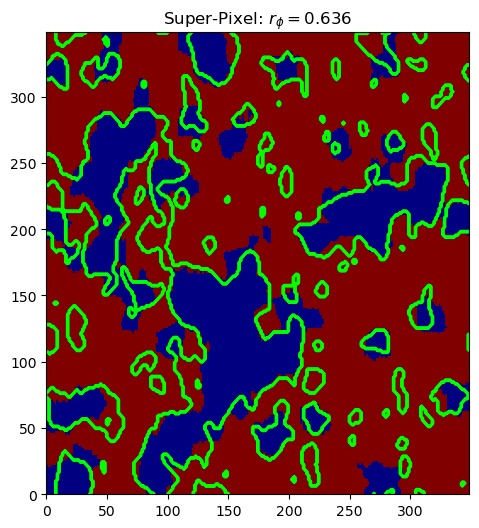

In [5]:
labels = t2c.slic_cube(cube=dT_smooth,
                       n_segments=5000,
                       compactness=0.1,
                       max_iter=20,
                       sigma=0,
                       min_size_factor=0.5,
                       max_size_factor=3,
                       cmap=None)

xHII_stitch = t2c.stitch_superpixels(data=dT_smooth,
                                     labels=labels,
                                     bins='knuth',
                                     binary=True,
                                     on_superpixel_map=True)

mask_xHI = t2c.smooth_coeval(xfrac, z, box_size_mpc=boxsize, max_baseline=2.0, nu_axis=2) < 0.5
phicoef_sup = matthews_corrcoef(mask_xHI.flatten(), 1-xHII_stitch.flatten())

plt.rcParams['figure.figsize'] = [12, 6]
plt.subplot(121)
plt.title('Super-Pixel: $r_{\phi}=%.3f$' %phicoef_sup)
plt.pcolormesh(x, y, 1-xHII_stitch[0], cmap='jet')
plt.contour(mask_xHI[0], colors='lime', extent=[0, boxsize, 0, boxsize])


## SegU-Net

In [6]:
seg = t2c.segmentation.segunet21cm(tta=2, verbose=True)

dT_cut = dT_smooth[:128,:128,:128]
mask_xHI2 = mask_xHI[:128,:128,:128]

xHI_seg, xHI_seg_err = seg.prediction(x=dT_cut)
phicoef_seg = matthews_corrcoef(mask_xHI2.flatten(), xHI_seg.flatten())

xHI_sup = xHII_stitch[:128,:128,:128]
phicoef_sup = matthews_corrcoef(mask_xHI2.flatten(), 1-xHI_sup.flatten())

fig, axs = plt.subplots(figsize=(12,6), ncols=3, sharey=True, sharex=True)
(ax0, ax1, ax2) = axs

ax0.set_title('Super-Pixel ($r_{\phi}=%.3f$)' %phicoef_sup)
ax0.imshow(1-xHI_sup[0], origin='lower', cmap='jet', extent=[0, boxsize, 0, boxsize])
ax0.contour(mask_xHI2[0], colors='lime', extent=[0, boxsize, 0, boxsize])
ax0.set_xlabel('x [Mpc]')

ax1.set_title('SegU-Net ($r_{\phi}=%.3f$)' %phicoef_seg)
ax1.imshow(xHI_seg[0], origin='lower', cmap='jet', extent=[0, boxsize, 0, boxsize])
ax1.contour(mask_xHI2[0], colors='lime', extent=[0, boxsize, 0, boxsize])
ax1.set_xlabel('x [Mpc]')

ax2.set_title('SegUNet Pixel-Error')
im = ax2.imshow(xHI_seg_err[0], origin='lower', cmap='jet', extent=[0, boxsize, 0, boxsize])
fig.colorbar(im, label=r'$\sigma_{std}$', ax=ax2, pad=0.02, cax=fig.add_axes([0.905, 0.25, 0.02, 0.51]))
ax2.set_xlabel('x [Mpc]')

plt.subplots_adjust(hspace=0.1, wspace=0.01)
for ax in axs.flat: ax.label_outer()


tot number of (unique) manipulation we can do on a cube: 28


2023-05-08 08:31:19.383152: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


NameError: Exception encountered when calling layer "lambda" (type Lambda).

name 'array_ops' is not defined

Call arguments received by layer "lambda" (type Lambda):
  • inputs=tf.Tensor(shape=(None, 128, 128, 1), dtype=float32)
  • mask=None
  • training=None